In [1]:
%matplotlib inline
import numpy as np
from sklearn.covariance import empirical_covariance

from regain import datasets
from regain.covariance import latent_graphical_lasso_, latent_time_graphical_lasso_

# config
np.random.seed(0)
n_samples = 100
n_dim_obs = 10
n_dim_lat = 2
T = 10
tau = 0.1
alpha = 0.1

dataset = datasets.make_dataset(
        n_samples=n_samples, n_dim_lat=n_dim_lat, update_ell='fixed',
        update_theta='l2', normalize_starting_matrices=True, n_dim_obs=n_dim_obs, T=T)

## 1. Single timestamp
Check if, with only one timestamp, the method behave the same as Chandrasekaran/Ma.

In [2]:
emp_cov = empirical_covariance(dataset.data[0], assume_centered=False)

### 1.1 Do we behave as ourselves with the same functional as Ma?
The following is the latent time graphical model inference with only one covariance matrix.

In [3]:
results_time = latent_time_graphical_lasso_.latent_time_graphical_lasso(
    emp_cov[None, ...], alpha=alpha, tau=tau,
    tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    verbose=0, max_iter=500)

We compare it with the code for the latent graphical model inference (without time). <br>
Since there is only one covariance matrix, we expect to obtain the same results.

In [4]:
results_static = latent_graphical_lasso_.latent_graphical_lasso(
    emp_cov, alpha=alpha, tau=tau, 
    tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500)

In [5]:
assert np.all([np.allclose(x, y) for x, y in zip(results_static, results_time)])
assert np.linalg.matrix_rank(results_static[1]) == np.linalg.matrix_rank(results_time[1][0])

### Optional (requires Matlab installed)
Now we check if the result is the same as the LVGLASSO Matlab algorithm. To do that, we implemented a simple wrapper which rely on `matlab.engine`, to run Matlab code directly from Python. It requires Matlab 2016 or higher installed.

In [5]:
from regain.wrapper.matlab import lvglasso
from sklearn.datasets.base import Bunch

result = lvglasso(emp_cov, alpha, tau, 1. / emp_cov.shape[0])
ma_output = Bunch(**result)

assert np.all([np.allclose(x, y, atol=1e-3) for x, y in zip(results_static[:2], (ma_output.S, ma_output.L))])
assert np.linalg.matrix_rank(ma_output.L) == np.linalg.matrix_rank(results_time[1][0])

## 2. Time-varying vs separate for each time
This is to justify the choice of the additional penalties which constrain subsequent matrices in time to behave similarly.

In [22]:
# config
n_samples = 100
n_dim_obs = 10
n_dim_lat = 2
T = 10

np.random.seed(0)

dataset = datasets.make_dataset(
        n_samples=n_samples, n_dim_lat=n_dim_lat, update_ell='fixed',
        update_theta='l2', normalize_starting_matrices=True, n_dim_obs=n_dim_obs, T=T)

X, y = dataset.X, dataset.y

First, we check again if the results are the same with beta and eta is 0.

In [23]:
emp_cov = np.array([empirical_covariance(data, assume_centered=False) for data in dataset.data])
emp_list = np.array(emp_cov).transpose(1,2,0)

In [24]:
results_time = latent_time_graphical_lasso_.latent_time_graphical_lasso(
    emp_cov, alpha=alpha, tau=tau, tol=1e-5, rtol=1e-5, rho=1./ emp_cov.shape[0],
    beta=0, eta=0,
    verbose=0, max_iter=500)

results_static = [latent_graphical_lasso_.latent_graphical_lasso(
    x, alpha=alpha, tau=tau, tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
    verbose=0, max_iter=500) for x in emp_cov]

In [25]:
assert np.all([np.allclose(results_static[i][0], results_time[0][i], atol=1e-2) for i in range(10)])
assert np.all([np.linalg.matrix_rank(results_static[i][1]) == np.linalg.matrix_rank(results_time[1][i])
        for i in range(10)])

Again, optional: it requires Matlab installed.

In [ ]:
result = lvglasso(emp_list, alpha, tau, 1/emp_list[0].shape[0])
ma_output = Bunch(**result)

ma_output.R = np.array(ma_output.R)
ma_output.S = np.array(ma_output.S)
ma_output.L = np.array(ma_output.L)

assert np.allclose(results_time[0], ma_output.R + ma_output.L, atol=1e-3)

L = np.array(ma_output.L)
LL = results_time[1]

ranks_ma = [np.linalg.matrix_rank(l)for l in L]
ranks_ours = [np.linalg.matrix_rank(l)for l in LL]
assert np.all([np.linalg.matrix_rank(l) == np.linalg.matrix_rank(ll) for l, ll in zip(L, LL)])

# Penalty contribution

We now checked that in the limit case of one time and in the case in which we do not consider the penalties that involve time we perform equivalentely. Now, with CV on the parameters on synhtetic data generated with norm2 we want to see if our method performs better than LVGLASSO applied on different time stamps. 

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from regain import utils
from regain.covariance import LatentTimeGraphicalLasso

ltgl = GridSearchCV(
    LatentTimeGraphicalLasso(),
    dict(tau=np.logspace(-2,np.log(.5),10), alpha=np.logspace(-2,np.log(.5),10)),
    cv=StratifiedShuffleSplit(10), return_train_score=True).fit(X, y)

In [ ]:
emp_list = list(ltgl.best_estimator_.covariance_)
alpha = ltgl.best_params_['alpha']
tau = ltgl.best_params_['tau']

In [ ]:
precs = []
lats = []
covss = []
for data in dataset.data:
    lgl = LatentGraphicalLasso(tau=tau, alpha=alpha, assume_centered=False).fit(X, y)
    precs.append(lgl.precision_)
    lats.append(lgl.latent_)
    covss.append(lgl.covariance_)

### Error obtained w.r.t. the observed data

In [ ]:
from regain.utils import error_norm_time
print("Error norm time with observed precision: \n LTGL: {:.3f}\n LVGLASSO: {:.3f}".format(
      error_norm_time(ltgl.best_estimator_.precision_ - ltgl.best_estimator_.latent_, dataset.thetas_observed),
      error_norm_time(np.array(precs) - np.array(lats), dataset.thetas_observed)))

### Error obtained w.r.t. the real data

In [ ]:
print("Error norm time of LTGL: \n Precision: {:.3f}\n Latent: {:.3f}\n".format(
      error_norm_time(ltgl.best_estimator_.precision_, dataset.thetas),
      error_norm_time(ltgl.best_estimator_.latent_, dataset.ells)))

print("Error norm time of LVGLASSO: \n Precision: {:.3f}\n Latent: {:.3f}".format(
      error_norm_time(np.array(precs), dataset.thetas),
      error_norm_time(np.array(lats), dataset.ells)))

### Error in ranks

In [ ]:
# ltgl.best_estimator_.set_params(beta=1e12,eta=1e12).fit(data_grid)
print("Rank latent matrices LTGL: {}".format([np.linalg.matrix_rank(i) for i in ltgl.best_estimator_.latent_]))
print("Rank latent matrices LVGLASSO: {}".format([np.linalg.matrix_rank(i) for i in lats]))
print("Rank true latent matrices: {}".format(np.linalg.matrix_rank(dataset.ells)))

### Error in structure

In [ ]:
from regain.utils import structure_error

print("f1 score LTGL: {:.2f}".format(structure_error(
    dataset.thetas, ltgl.best_estimator_.precision_, thresholding=1, eps=1e-2)['f1']))
print("f1 score LVGLASSO: {:.2f}".format(structure_error(
    dataset.thetas, np.array(precs), thresholding=1, eps=1e-2)['f1']))

# Scalability

In [10]:
from tqdm import tqdm

In [44]:
n_samples = 100
# n_dim_obs = 10
n_dim_lat = 2
T = 10
np.random.seed(0)
import time
results = {}
    
for n_dim_obs in tqdm(np.logspace(1, 2, 5)):
    dataset = datasets.make_dataset(
        n_samples=n_samples, n_dim_lat=n_dim_lat, update_ell='fixed',
        update_theta='l2', normalize_starting_matrices=True, n_dim_obs=n_dim_obs, T=T)

    X, y = dataset.X, dataset.y

    emp_cov = np.array([empirical_covariance(data, assume_centered=False) for data in dataset.data])
    emp_list = np.array(emp_cov).transpose(1,2,0)

    res, elapsed_time = [], []
    for x in emp_cov:
        tic = time.time()
        results_static = latent_graphical_lasso_.latent_graphical_lasso(
            x, alpha=alpha, tau=tau, tol=1e-5, rtol=1e-5, rho=1. / emp_cov.shape[0],
        verbose=0, max_iter=500)
        tac = time.time() - tic
        
        res.append(results_static)
        elapsed_time.append(tac)
        
    results[('lgl', n_dim_obs)] = dict(res=res, elapsed_time=elapsed_time)
    
    res, elapsed_time = [], []
    for x in emp_cov:
        tic = time.time()
        result = lvglasso(x, alpha, tau, 1. / x.shape[0])
        ma_output = Bunch(**result)

        ma_output.R = np.array(ma_output.R)
        ma_output.S = np.array(ma_output.S)
        ma_output.L = np.array(ma_output.L)
        tac = ma_output.elapsed_time #time.time() - tic
        
        res.append(ma_output)
        elapsed_time.append(tac)
    

    results[('lvglasso', n_dim_obs)] = dict(res=ma_output, elapsed_time=elapsed_time)
#     results[('lvglasso', n_dim_obs)] = ma_output

    # assert np.allclose(results_time[0], ma_output.R + ma_output.L, atol=1e-3)

#     L = np.array(ma_output.L)
#     LL = results_time[1]

#     ranks_ma = [np.linalg.matrix_rank(l)for l in L]
#     ranks_ours = [np.linalg.matrix_rank(l)for l in LL]
    # assert np.all([np.linalg.matrix_rank(l) == np.linalg.matrix_rank(ll) for l, ll in zip(L, LL)])

100%|██████████| 5/5 [00:38<00:00,  7.71s/it]


In [24]:
import pandas as pd

In [69]:
import pandas as pd

In [76]:
df = pd.DataFrame({k: (results[k]['elapsed_time']) for k in results}).T.unstack(level=0)# .plot(logy=True)

In [82]:
df = df.stack()

In [95]:
pd.Index

pandas.core.indexes.base.Index

No handles with labels found to put in legend.


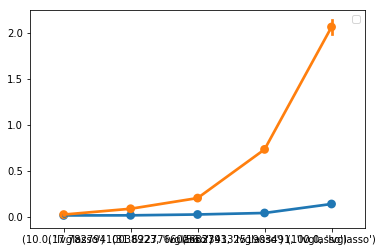

In [126]:
from matplotlib import pyplot as plt
f, ax = plt.subplots()
sns.pointplot(data=df.loc[pd.IndexSlice[:, 'lgl'], :].T, ax=ax, label='lgl')
sns.pointplot(data=df.loc[pd.IndexSlice[:, 'lvglasso'], :].T, ax=ax, color='C1', label='lvglasso')
ax.legend();

In [128]:
df.index.levels[1]

Index(['lgl', 'lvglasso'], dtype='object')

In [137]:
df.unstack(level=0)

0                                                      1  \
         10.000000  17.782794  31.622777  56.234133  100.000000 10.000000    
lgl        0.021276   0.030052   0.029721   0.046583   0.139973   0.019926   
lvglasso   0.023085   0.086299   0.235088   0.757566   1.903312   0.023612   

                                                        ...              8  \
         17.782794  31.622777  56.234133  100.000000    ...     10.000000    
lgl        0.025479   0.025369   0.046815   0.147044    ...       0.015779   
lvglasso   0.084791   0.194852   0.723097   2.129311    ...       0.020990   

                                                              9             \
         17.782794  31.622777  56.234133  100.000000 10.000000  17.782794    
lgl        0.014611   0.026669   0.042431   0.133297   0.015443   0.013424   
lvglasso   0.093061   0.234053   0.698075   1.968895   0.023706   0.065906   

                                           
         31.622777  56.234133  100.000000  
lgl        0.027896   0.046859   0.134067  
lvglasso   0.189966   0.753133   1.974160  

[2 rows x 50 columns]

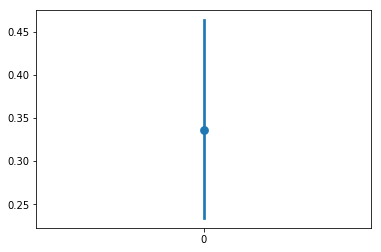

In [147]:
sns.pointplot(data=df.T.unstack(level=0))

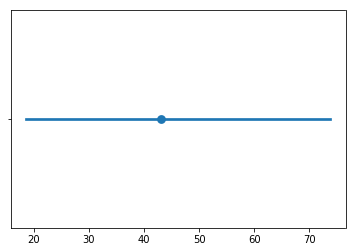

In [92]:
import seaborn as sns
sns.pointplot(x=df.index.levels[0], data=df)
